In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from utils import data_reading, music_generation
from models import music_generation_VAE
from dataset import iterable_dataset
import os
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from models import feature_prediction_gru


In [166]:
SEQ_LEN = 48
RESOLUTION = 12
TRAIN_SPLIT = 0.8
CUT_TIME_RATIO = 0.1
TEST_FILE_NUMBER = 3
BATCH_SIZE = 64
LATENT_SIZE = 513
HIDDEN_SIZE = 512
N_LAYER = 3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CUTOFF_P = 1.5
BUFFER_SIZE = 10
FILES_TO_READ = 10
PROJECT_DIR ="D:/522 project"
PPR_DIR = "lpd_5_pianoroll"
SAVE_DIR = "./vae_piano"
TRACK_ORDER = ["Piano"]
#with open(SCALER_DICT_SAVE_PATH, "rb") as file:
#    scaler_dict = pickle.load(file)
scaler_dict = None
PATH = os.path.join(PROJECT_DIR, PPR_DIR)
VAE_MODEL_STATE_PATH = "./vae_piano/P_vae_trained_r12s48d25e20"
GRU_MODEL_STATE_PATH = "./latent_learner_gru_piano_100"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae_model = music_generation_VAE.ConvVAE(TRACK_ORDER, HIDDEN_SIZE)
vae_model.load_state_dict(torch.load(VAE_MODEL_STATE_PATH))
vae_model.to(DEVICE)
latent_predict_model = feature_prediction_gru.FeaturePredictionGRU(TRACK_ORDER, LATENT_SIZE, HIDDEN_SIZE, BATCH_SIZE, N_LAYER, DEVICE)
latent_predict_model.load_state_dict(torch.load(GRU_MODEL_STATE_PATH))
latent_predict_model.to(DEVICE)

FeaturePredictionGRU(
  (gru): GRU(513, 512, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=768, bias=True)
  (bn2): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=768, out_features=513, bias=True)
)

In [171]:
all_files_list = data_reading.read_all_npzs(PATH, shuffle=True)
all_files_list = all_files_list[:TEST_FILE_NUMBER]
piano_dataset = iterable_dataset.IterableSongDataset(all_files_list, SEQ_LEN, RESOLUTION, TRACK_ORDER, 
                                          method="shift_window", normalize=False, binarize=False,
                                          buffer_size=BUFFER_SIZE, files_to_read=FILES_TO_READ)

In [172]:
original_tracks_dict, generated_tracks_dict = music_generation.check_vae_generation(vae_model, piano_dataset, DEVICE)
orignal_tracks = music_generation.binarize_generated_music_dict(original_tracks_dict, 5, False, vol=85)
generated_tracks = music_generation.binarize_generated_music_dict(generated_tracks_dict, 10, False, vol=85)
orignal_tracks = music_generation.create_multitrack(orignal_tracks, RESOLUTION)
generated_tracks = music_generation.create_multitrack(generated_tracks, RESOLUTION)

reloading
torch.Size([1, 10800, 128])
torch.Size([1, 10800, 128])
Piano mean:  tensor(1.1814, device='cuda:0')
Piano mean:  tensor(1.0951, device='cuda:0', grad_fn=<MeanBackward0>)


[<AxesSubplot:xlabel='time (beat)', ylabel='Piano\n\npitch'>]

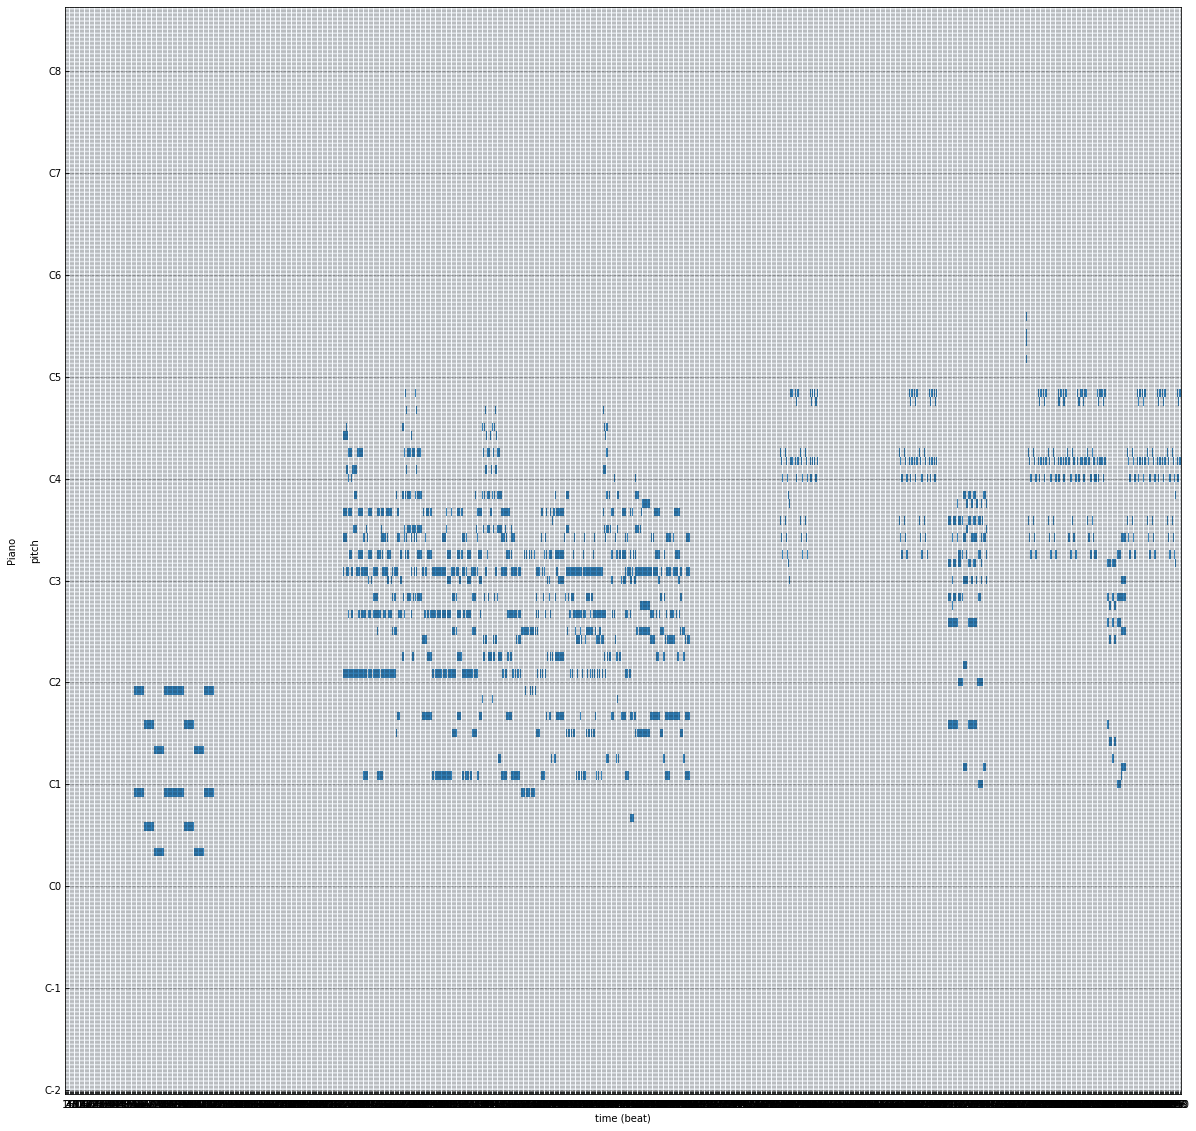

In [173]:
plt.rcParams["figure.figsize"] = (20,20)
orignal_tracks.plot()

[<AxesSubplot:xlabel='time (beat)', ylabel='Piano\n\npitch'>]

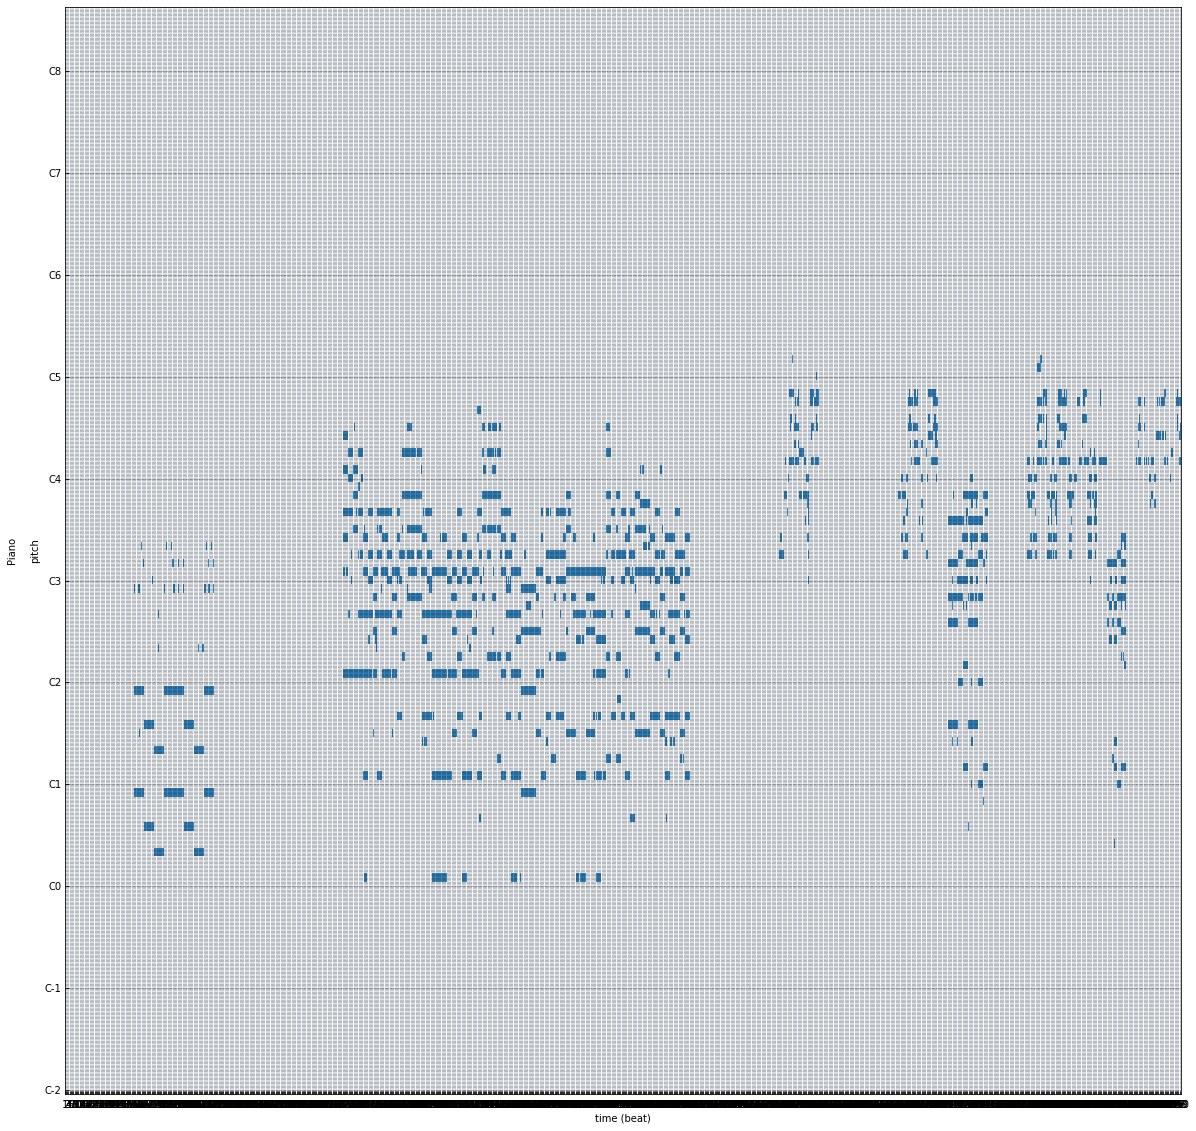

In [174]:
generated_tracks.plot()

In [175]:
res_list = []
for song_seq, _ in piano_dataset:
    song_seq = torch.from_numpy(song_seq).unsqueeze(0).float().to(DEVICE)
    transformed_track = vae_model.encode(song_seq).squeeze().detach().cpu().numpy()
    res_list.append(transformed_track)
latent_piano = np.stack(res_list)

reloading


In [176]:
latent_piano

array([[ 0.10880173, -0.27602598, -0.23547278, ..., -0.13231699,
         0.2156321 , -0.21622065],
       [ 0.10880173, -0.27602598, -0.23547278, ..., -0.13231699,
         0.2156321 , -0.21622065],
       [ 0.10880173, -0.27602598, -0.23547278, ..., -0.13231699,
         0.2156321 , -0.21622065],
       ...,
       [-0.02848055,  0.2716756 , -0.32160455, ...,  0.23689844,
        -0.12523626, -0.3350779 ],
       [ 0.00620751,  0.31728533, -0.40059847, ...,  0.19502977,
        -0.26869792, -0.3314299 ],
       [ 0.36368495, -0.12423672, -0.11394365, ...,  0.1794535 ,
         0.05645777, -0.3099488 ]], dtype=float32)

In [177]:
prelude_dict = music_generation.create_tracks_dict_from_tensor(latent_piano[np.newaxis,0:2], TRACK_ORDER)

In [178]:
generated_latent_dict = music_generation.music_generation_rnn(latent_predict_model, None, TRACK_ORDER, prelude_dict, 88
                                                             ,DEVICE)

In [179]:
latent_piano = generated_latent_dict["Piano"]

In [180]:
latent_piano.shape

torch.Size([88, 513])

In [181]:
latent_points = music_generation_VAE.rsample(latent_piano, 1)

In [182]:
results = vae_model.decode(latent_points)

In [183]:
results.shape

torch.Size([88, 1, 1, 48, 128])

In [184]:
results = results.reshape(-1, 128)

In [185]:
results = torch.softmax(results, dim=1)

In [186]:
results.max()

tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)

In [187]:
results.shape

torch.Size([4224, 128])

Piano mean:  tensor(0.0078, device='cuda:0', grad_fn=<MeanBackward0>)


[<AxesSubplot:xlabel='time (beat)', ylabel='Piano\n\npitch'>]

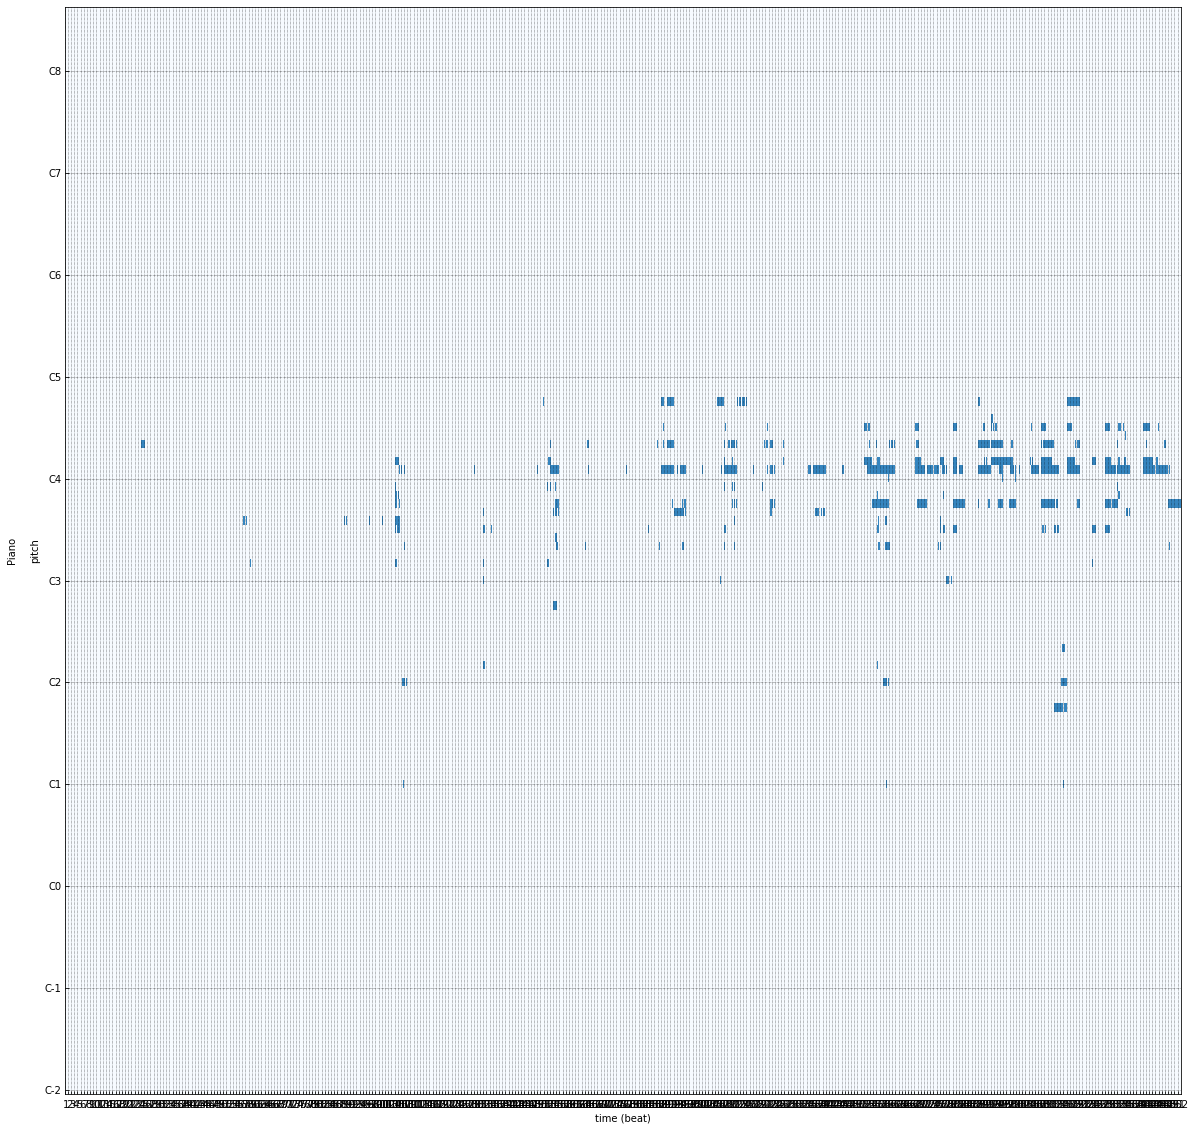

In [191]:
generated_dict = music_generation.create_tracks_dict_from_tensor(results.unsqueeze(0), TRACK_ORDER)
generated_dict = music_generation.binarize_generated_music_dict(generated_dict, 0.02, False)
generated_music = music_generation.create_multitrack(generated_dict, RESOLUTION)
generated_music.plot()

In [192]:
generated_music.write("new_music.mid")

In [193]:
orignal_tracks.write("new_original.mid")